# Selecting Characteristics in Generated Images

In [1]:
import pandas as pd 
import os , shutil
import torch 
import torchvision
from torchvision import transforms as T 
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import Linear,ReLU,Sequential,Dropout,Sigmoid,Tanh , Conv2d,LeakyReLU,BatchNorm2d,Flatten,ConvTranspose2d
import matplotlib.pyplot as plt 

In [2]:
#eyeglasses dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jeffheaton/glasses-or-no-glasses")

print("Path to dataset files:", path)

Path to dataset files: /home/billy/.cache/kagglehub/datasets/jeffheaton/glasses-or-no-glasses/versions/2


In [3]:
train = pd.read_csv(path+'/train.csv')
train.set_index('id',inplace=True)

In [4]:
G='files/glasses/G/'
NoG='files/glasses/NoG/'

In [5]:

# os.makedirs(G,exist_ok=True)
# os.makedirs(NoG,exist_ok=True)
# folder = path+'/faces-spring-2020/faces-spring-2020/'
# for i in range(1,4501):
#     oldpath=f"{folder}face-{i}.png"
#     if train.loc[i]['glasses']==0:
#         newpath=f"{NoG}face-{i}.png"
#     elif train.loc[i]['glasses']==1:
#         newpath=f"{G}face-{i}.png"
#     shutil.move(oldpath,newpath)

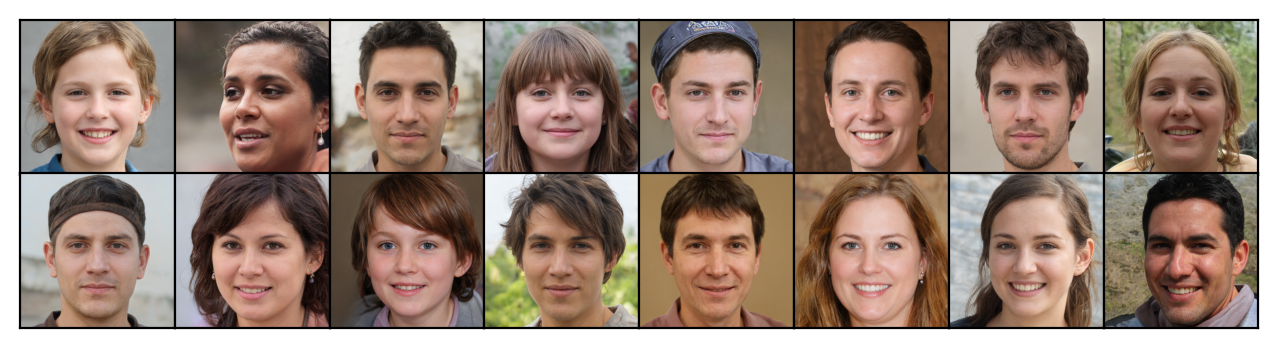

In [6]:
import random
import matplotlib.pyplot as plt
from PIL import Image
imgs=os.listdir(NoG)
random.seed(42)
samples=random.sample(imgs,16)
fig=plt.figure(dpi=200, figsize=(8,2))
for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    img=Image.open(f"{NoG}{samples[i]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.01,hspace=-0.01)
plt.show()

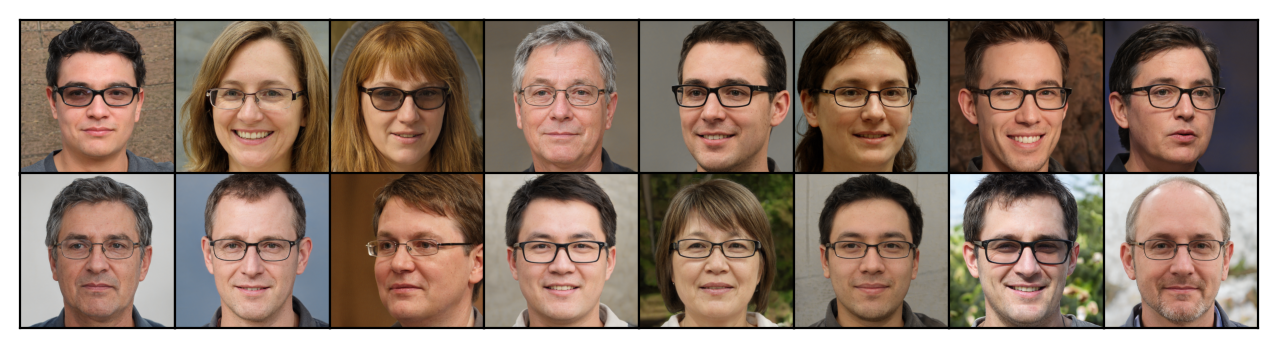

In [7]:
imgs=os.listdir(G)
random.seed(42)
samples=random.sample(imgs,16)
fig=plt.figure(dpi=200, figsize=(8,2))
for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    img=Image.open(f"{G}{samples[i]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.01,hspace=-0.01)
plt.show()

# wGAN

<img src="images/wGAN.png" height=2000, width=2500>

# cGAN
<img src="images/cGAN.png" height=2000, width=2500>

In [8]:
# creating a GAN
class Critic(nn.Module):
    def __init__(self,img_ch,features):
        super().__init__()
        self.net=Sequential(
            Conv2d(img_ch,features,kernel_size=4,stride=2,padding=1),
            LeakyReLU(0.2),
            self.block(features,features*2,4,2,1),
            self.block(features*2,features*4,4,2,1),
            self.block(features*4,features*8,4,2,1),
            self.block(features*8,features*16,4,2,1),
            self.block(features*16,features*32,4,2,1),
            Conv2d(features*32,1,kernel_size=4,stride=2,padding=0)
        )

    def block(self,in_channel,out_channel,kernel_size,stride,padding):
            return Sequential(
                Conv2d(in_channel,out_channel,kernel_size,stride,padding,bias=False),
                nn.InstanceNorm2d(out_channel,affine=True),
                LeakyReLU(0.2)
            )

    def forward(self,x):
            return self.net(x)

In [9]:
# Generator 
class Gen(nn.Module):
    def __init__(self,noise_ch,img_ch,features):
        super(Gen,self).__init__()
        self.net=Sequential(
            self.block(noise_ch,features*64,4,1,0),
            self.block(features*64,features*32,4,2,1),
            self.block(features*32,features*16,4,2,1),
            self.block(features*16,features*8,4,2,1),
            self.block(features*8,features*4,4,2,1),
            self.block(features*4,features*2,4,2,1),
            ConvTranspose2d(features*2,img_ch,kernel_size=4,stride=2,padding=1),
            Tanh()
            
            
        )

    def block(self,in_ch,out_ch,kernel_size,stride,padding):
        return Sequential(
            ConvTranspose2d(in_ch,out_ch,kernel_size,stride,padding,bias=False),
            BatchNorm2d(out_ch),
            ReLU()
        )
    def forward(self,x):
        return self.net(x)

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(nn.bias.data,0)
        

In [11]:
device ='cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
z_dim=100 #dimension of latent space 
img_ch = 3
features =16
gen=Gen(z_dim+2,img_ch,features).to(device)
cr=Critic(img_ch+2,features).to(device)
weights_init(gen)
weights_init(cr)

In [13]:
lr=0.0001
opt_gen= torch.optim.Adam(gen.parameters(),lr=lr,betas=(0.0,0.9))
opt_cr= torch.optim.Adam(cr.parameters(),lr=lr,betas=(0.0,0.9))

In [14]:
def GP(cr,real,fake):
    B,C,H,W = real.shape
    aplha = torch.rand((B,1,1,1)).repeat(1,C,H,W).to(device)
    interpolated_image = real*aplha+fake*(1-aplha)
    cr_score = cr(interpolated_image)
    gradient = torch.autograd.grad(
        inputs=interpolated_image,
        outputs=cr_score,
        grad_outputs=torch.ones_like(cr_score),
        create_graph=True,
        retain_graph=True
    )[0]
    gradient=gradient.view(gradient.shape[0],-1)
    gradient_norm = gradient.norm(2,dim=1)
    gp=torch.mean((gradient_norm-1)**2)
    return gp
    

In [15]:
# adding labels to inputs 
batch_sz= 32
img_sz=256
transform = T.Compose([
    T.Resize((img_sz,img_sz)),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

data_set = ImageFolder(root=r'files/glasses',
                      transform=transform)

FileNotFoundError: Found no valid file for the classes .ipynb_checkpoints. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [ ]:
newdata=[]
for i,(img,label) in enumerate(data_set):
    onehot=torch.zeros((2))
    onehot[label]=1
    channels=torch.zeros((2,img_sz,img_sz))
    if label==0:
        channels[0,:,:]=1
    else:
        channels[1,:,:]=1    
    img_and_label=torch.cat([img,channels],dim=0)    
    newdata.append((img,label,onehot,img_and_label))


In [19]:
data_loader=torch.utils.data.DataLoader(
    newdata,batch_size=batch_sz,shuffle=True)


NameError: name 'newdata' is not defined

In [ ]:
def plot_epoch(epoch):
    # test images with glasses
    noise = torch.randn(32, z_dim, 1, 1)
    labels = torch.zeros(32, 2, 1, 1)
    # use label [1,0] so G knows what to generate
    labels[:,0,:,:]=1
    noise_and_labels=torch.cat([noise,labels],dim=1).to(device)
    fake=gen(noise_and_labels).cpu().detach()
    fig=plt.figure(figsize=(20,10),dpi=100)
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.savefig(f"files/glasses/G{epoch}.png")
    plt.show() 
    # test images without glasses
    noise = torch.randn(32, z_dim, 1, 1)
    labels = torch.zeros(32, 2, 1, 1)
    # use label [0,1] so G knows what to generate
    labels[:,1,:,:]=1
    noise_and_labels=torch.cat([noise,labels],dim=1).to(device)
    fake=gen(noise_and_labels).cpu().detach()
    fig=plt.figure(figsize=(20,10),dpi=100)
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.savefig(f"files/glasses/NoG{epoch}.png")
    plt.show()     

In [ ]:
def train_batch(onehots,img_and_labels,epoch):
    real = img_and_labels.to(device)
    B = real.shape[0]
    # train critic five times
    for _ in range(5):
        noise = torch.randn(B, z_dim, 1, 1)
        onehots=onehots.reshape(B,2,1,1)
        noise_and_labels=torch.cat([noise,onehots],dim=1).to(device)
        fake_img = gen(noise_and_labels).to(device)
        fakelabels=img_and_labels[:,3:,:,:].to(device)
        fake=torch.cat([fake_img,fakelabels],dim=1).to(device)
        critic_real = cr(real).reshape(-1)
        critic_fake = cr(fake).reshape(-1)
        gp = GP(cr, real, fake)
        loss_critic=(-(torch.mean(critic_real) - 
           torch.mean(critic_fake)) + 10 * gp)
        opt_cr.zero_grad()
        loss_critic.backward(retain_graph=True)
        opt_cr.step()
    # train G
    gen_fake = cr(fake).reshape(-1)
    loss_gen = -torch.mean(gen_fake)
    opt_gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
    return loss_critic, loss_gen


In [ ]:
# for epoch in range(1,101):
#     closs=0
#     gloss=0
#     for _,_,onehots,img_and_labels in data_loader:    
#         # train a batch
#         loss_critic, loss_gen = train_batch(onehots,\
#                                 img_and_labels,epoch)   
#         closs+=loss_critic.detach()/len(data_loader)
#         gloss+=loss_gen.detach()/len(data_loader)
#     print(f"at epoch {epoch},\
#     critic loss: {closs}, generator loss {gloss}")
#     plot_epoch(epoch)
# torch.save(gen.state_dict(),'files/cgan.pth')


In [21]:
torch.manual_seed(0)
generator=Gen(z_dim+2,img_ch,features).to(device)
generator.load_state_dict(torch.load("files/cgan.pth",map_location=device))
generator.eval()

Gen(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(102, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): ConvTra

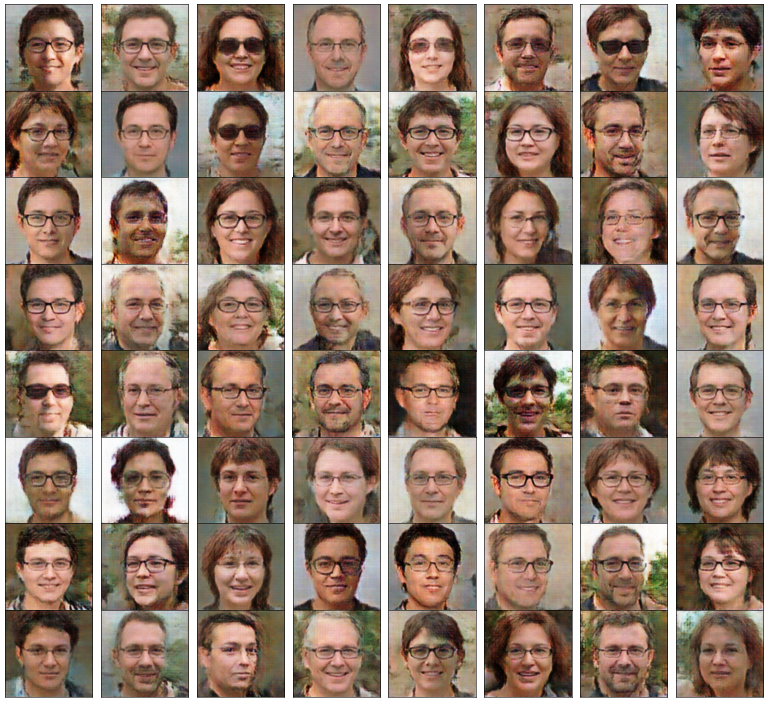

In [36]:
noise_g=torch.randn(64, z_dim, 1, 1)
labels_g=torch.zeros(64, 2, 1, 1)
labels_g[:,0,:,:]=1
noise_and_labels=torch.cat([noise_g,labels_g],dim=1).to(device)
fake=generator(noise_and_labels)
plt.figure(figsize=(20,18),dpi=50)
for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
    plt.imshow(img.numpy())
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.08,hspace=-0.01)
plt.savefig("files/gai/images/with_glasses.png", bbox_inches="tight", dpi=300)
plt.show()

In [25]:
z_male_g=noise_g[0]
z_female_g=noise_g[14]

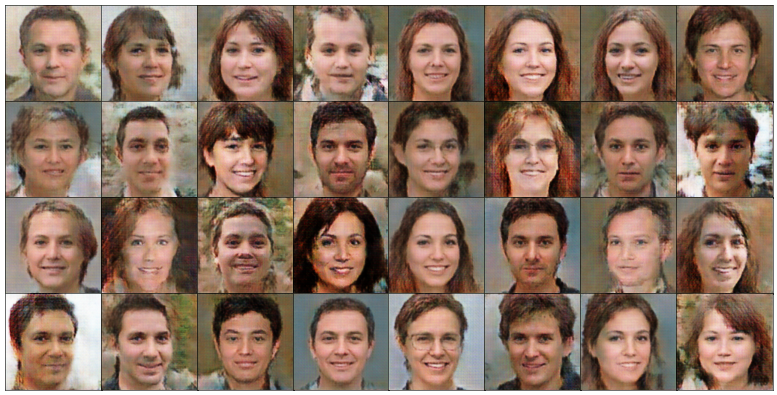

In [30]:
noise_ng = torch.randn(32, z_dim, 1, 1)
labels_ng = torch.zeros(32, 2, 1, 1)
labels_ng[:,1,:,:]=1
noise_and_labels=torch.cat([noise_ng,labels_ng],dim=1).to(device)
fake=generator(noise_and_labels).cpu().detach()
plt.figure(figsize=(20,10),dpi=50)
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
    plt.imshow(img.numpy())#.repeat(4,axis=0).repeat(4,axis=1))
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.08,hspace=-0.01)
plt.savefig("files/gai/images/without_glasses.png", bbox_inches="tight", dpi=300)
plt.show()

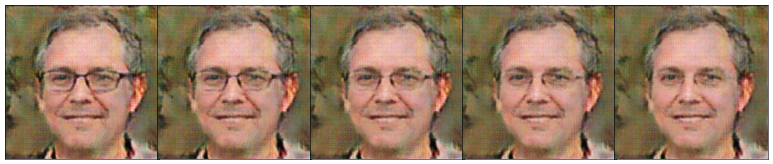

In [39]:
z_male_ng=noise_ng[12]
z_female_ng=noise_ng[1]
weights=[0,0.25,0.5,0.75,1]
plt.figure(figsize=(20,4),dpi=50)
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    # change the value of z
    label=weights[i]*labels_ng[0]+(1-weights[i])*labels_g[0]
    noise_and_labels=torch.cat(
        [z_female_g.reshape(1, z_dim, 1, 1),
         label.reshape(1, 2, 1, 1)],dim=1).to(device)    
    fake=generator(noise_and_labels).cpu().detach()    
    img=(fake[0]/2+0.5).permute(1,2,0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.08,hspace=-0.01)
plt.savefig("files/gai/images/transition.png", bbox_inches="tight", dpi=300)
plt.show()

In [28]:
os.makedirs("files/gai/images", exist_ok=True)

### RESULTS
<div style="display: flex; justify-content: space-between;">
    <div style="text-align: center;">
        <p>FIRST EPOCH</p>
        <img src="files/gai/images/Epoch1.png" alt="Epoch 1" style="width: 700px;"/>
    </div>
    <div style="text-align: center;">
        <p>FINAL EPOCH</p>
        <img src="files/gai/images/with_glasses.png" alt="Final Epoch" style="width: 700px;"/>
    </div>
</div>

<div style="display: flex; justify-content: space-between;">
    <div style="text-align: center;">
        <p>Without Glasses</p>
        <img src="files/gai/images/without_glasses.png" alt="Without Glasses" style="width: 700px;"/>
    </div>
    <div style="text-align: center;">
        <p>TRANSITION</p>
        <img src="files/gai/images/transition.png" alt="Transition" style="width: 700px;"/>
    </div>
</div>

